In [1]:
import darts 
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import warnings
import optuna
import scipy

from darts.dataprocessing.transformers import Scaler
from darts.models.filtering.gaussian_process_filter import GaussianProcessFilter
from darts.models.filtering.kalman_filter import KalmanFilter
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.metrics import mae, mse, smape

from darts.models.forecasting.nhits import NHiTSModel
from darts.models.forecasting.nbeats import NBEATSModel
from darts.models.forecasting.transformer_model import TransformerModel

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
warnings.filterwarnings('ignore')
plt.style.use('default')

%matplotlib inline

/home/douglas/miniconda3/envs/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


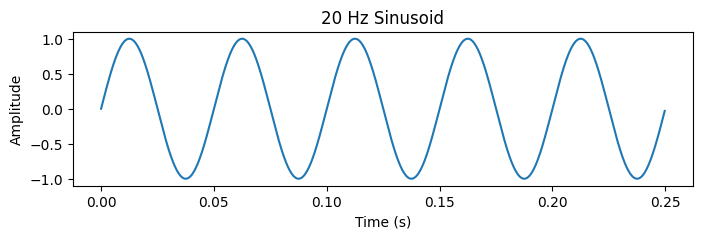

In [2]:
Fs = 1000 # Sample rate
t  = np.linspace(0, 0.25, Fs, False) # Time
f  = 20 # Frequency in Hz
signal = np.sin(2 * np.pi * f * t)

plt.figure(figsize = (8,2))
plt.title(f'{f} Hz Sinusoid')
plt.plot(t, signal)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

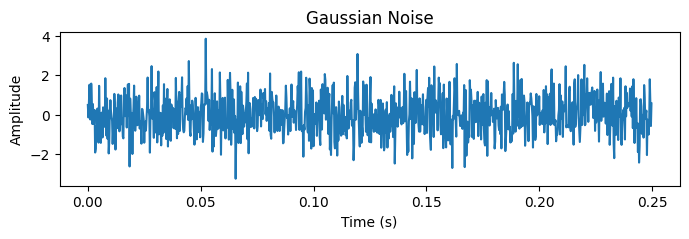

In [3]:
noise = np.random.normal(0, 1, size=len(t))

plt.figure(figsize=(8,2))
plt.title('Gaussian Noise')
plt.plot(t, noise)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

(array([  1.,   6.,  19.,  56.,  95., 173., 170., 188., 140.,  76.,  51.,
         15.,   8.,   1.,   1.]),
 array([-3.24126734, -2.76833408, -2.29540083, -1.82246757, -1.34953432,
        -0.87660106, -0.40366781,  0.06926545,  0.5421987 ,  1.01513196,
         1.48806521,  1.96099847,  2.43393172,  2.90686498,  3.37979824,
         3.85273149]),
 <BarContainer object of 15 artists>)

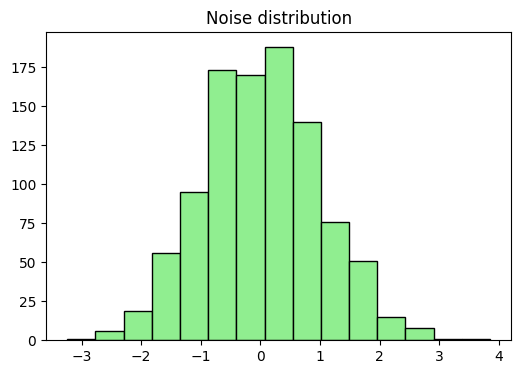

In [4]:
plt.figure(figsize= (6,4))
plt.title('Noise distribution')
plt.hist(noise, bins=15, color='lightgreen', ec='black')

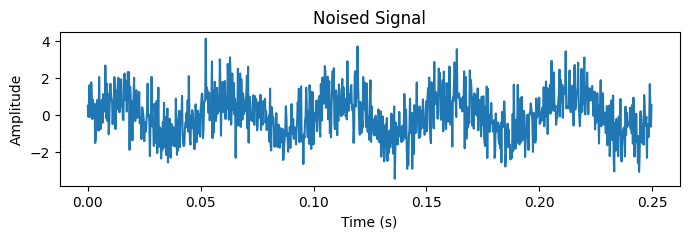

In [5]:
noised_signal = signal + noise

plt.figure(figsize=(8,2))
plt.title('Noised Signal')
plt.plot(t, noised_signal)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

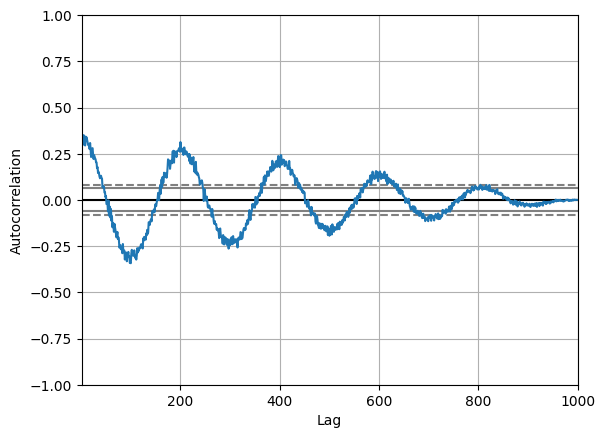

In [6]:
pd.plotting.autocorrelation_plot(pd.Series(noised_signal))

In [7]:
noised_signal = darts.TimeSeries.from_values(noised_signal)
scaled_signal = Scaler().fit_transform(noised_signal)

In [8]:
train_size = int(0.6 * len(scaled_signal))
train_samples, test_samples = scaled_signal[: train_size], scaled_signal[train_size: ]

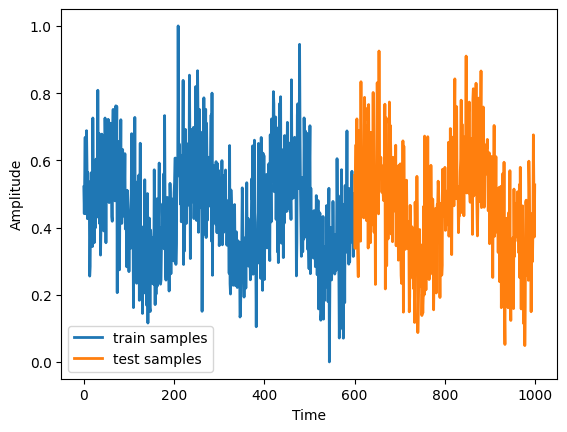

In [9]:
train_samples.plot(label='train samples')
test_samples.plot(label='test samples')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [10]:
if torch.cuda.is_available():
    pl_trainer_kwargs = {'accelerator'      : 'gpu',
                         'devices'          : -1,
                         'auto_select_gpus' : True}
else:
    pl_trainer_kwargs = {'accelerator' : 'cpu'}

In [11]:
input_size  = len(scaled_signal) // 4
output_size = len(scaled_signal) // 8
batch_size  = 256
epochs      = 1
dropout     = .2
lr          = 1e-3

In [21]:
models = [NHiTSModel(input_chunk_length = input_size,
                    output_chunk_length = output_size,
                    batch_size = batch_size,
                    dropout = dropout,
                    optimizer_kwargs = {'lr' : lr},
                    pl_trainer_kwargs = pl_trainer_kwargs),
         
         NBEATSModel(input_chunk_length = input_size,
                     output_chunk_length = output_size,
                     batch_size = batch_size,
                     dropout = dropout,
                     optimizer_kwargs = {'lr' : lr},
                     generic_architecture = True,
                     pl_trainer_kwargs = pl_trainer_kwargs), 
         
         #TransformerModel(input_chunk_length = input_size,
         #                  output_chunk_length = output_size,
         #                  batch_size = batch_size,
         #                  dropout = dropout,
         #                  optimizer_kwargs = {'lr' : lr},
         #                  d_model = 64,
         #                  nhead = 4,
         #                  pl_trainer_kwargs = pl_trainer_kwargs)
         ]

labels = ['NHITS', 'NBEATs']

def forecasting(list_of_models, train_samples, test_samples):
    forecast = []
    for model in list_of_models:
        model.fit(series = train_samples, epochs = epochs)
        forecast.append(model.predict(n = len(test_samples)))
    return forecast

In [19]:
results = forecasting(models, train_samples, test_samples)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.2 M 
---------------------------------------------------
1.0 M     Trainable params
128 K     Non-trainable params
1.2 M     Total params
4.610     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s, train_loss=0.290]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s, train_loss=0.290]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.48it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
31.974    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, train_loss=2.060]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, train_loss=2.060]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


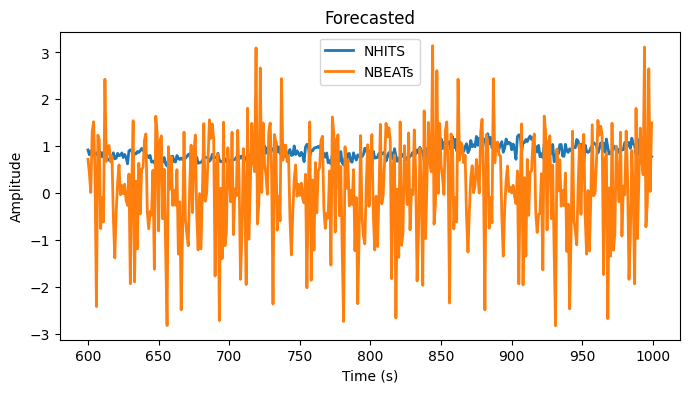

In [24]:
def plot_results(results, labels):
    plt.figure(figsize = (8,4))
    for idx, predicted in enumerate(results):
        predicted.plot(label=labels[idx])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Forecasted')

plot_results(results, labels)

In [ ]:
mae = mae(test_samples, pred_signal)
mse = mse(test_samples, pred_signal)
smape = smape(test_samples, pred_signal)

<BarContainer object of 2 artists>

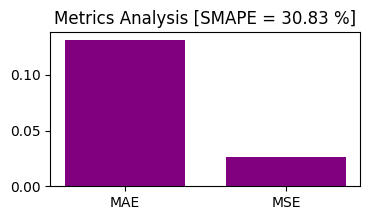

In [ ]:
metrics = {'MAE'   : mae,
           'MSE'   : mse}

plt.figure(figsize = (4,2))
plt.title(f'Metrics Analysis [SMAPE = {smape:.2f} %]')
plt.bar(list(metrics.keys()), 
        list(metrics.values()),
        color='purple',
        width = .75)

Text(0.5, 0, 'Time')

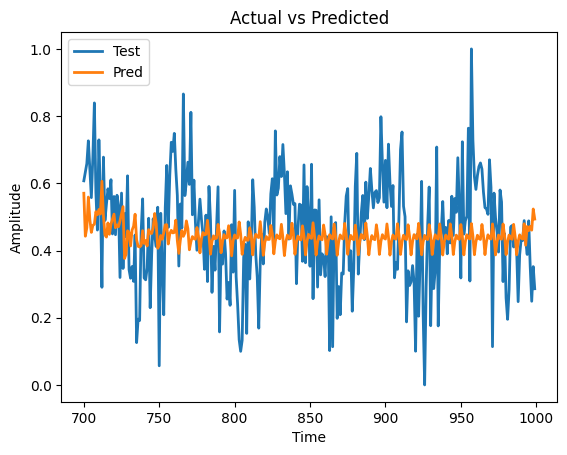

In [ ]:
test_samples.plot(label='Test')
pred_signal.plot(label='Pred')
plt.title('Actual vs Predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')

In [ ]:
original_signal = darts.TimeSeries.from_values(signal)[train_size: ]
original_signal = scaler.transform(original_signal)

filters = [GaussianProcessFilter(), KalmanFilter(dim_x=2).fit(original_signal), MovingAverageFilter(window=10)]
labels = ['Gaussian', 'Kalman', 'MovingAverage']

Text(0, 0.5, 'Amplitude')

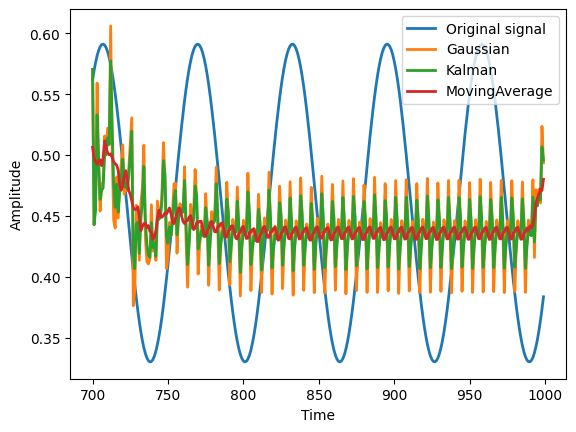

In [ ]:
original_signal.plot(label='Original signal')
for idx, filter in enumerate(filters):
    filted = filter.filter(pred_signal)
    filted.plot(label=f'{labels[idx]}')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
type(filted)

darts.timeseries.TimeSeries